İŞ PROBLEMİ

Facebook, kısa bir süre önce mevcut olan "maximumbidding" olarak adlandırılan teklif verme türüne alternatif olarak yeni bir teklif türü olan "averagebidding"i tanıttı. Müşterilerimizden biri olan bombabomba.com, bu yeni özelliği test etmeye karar verdi ve averagebidding'in maximumbidding'den daha fazla dönüşüm getirip getirmediğini anlamak için bir A/B testi yapmak istiyor.

A/B testi 1 aydır devam ediyor ve bombabomba.com şimdi sizden bu A/B testinin sonuçlarını analiz etmenizi bekliyor. Bombabomba.com için nihai başarı ölçütü "Purchase"dır. Bu nedenle, istatistiksel testler için "Purchase" metriğine odaklanılmalıdır.

Bir firmanın web site bilgilerini içeren bu veri setinde kullanıcıların gördükleri ve tıkladıkları reklam sayıları gibi bilgilerin yanı sıra buradan gelen kazanç bilgileri yer almaktadır.Kontrol ve Test grubu olmak üzere iki ayrı veri seti vardır. Bu veri setleri ab_testing.xlsx excel’inin ayrı sayfalarında yer almaktadır. Kontrol grubuna Maximum Bidding, test grubuna Average Bidding uygulanmıştır

Impression : Reklam görüntüleme sayısı	

Click	: Görüntülenen reklama tıklama sayısı

Purchase : Tıklanan reklamlar sonrası satın alınan ürün sayısı

Earning :  Satın alınan ürünler sonrası elde edilen kazanç

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal

In [40]:
# Adım 1: ab_testing_data.xlsx adlı kontrol ve test grubu verilerinden oluşan veri setini okutunuz. Kontrol ve test grubu verilerini ayrı değişkenlere atayınız.
df_control = pd.read_excel("ab_testing.xlsx", sheet_name="Control Group")
df_test = pd.read_excel("ab_testing.xlsx", sheet_name="Test Group")


In [18]:
df_control.head()

,Impression,Click,Purchase,Earning
0,82529.459271,6090.077317,665.211255,2311.277143
1,98050.451926,3382.861786,315.084895,1742.806855
2,82696.023549,4167.965750,458.083738,1797.827447
3,109914.400398,4910.882240,487.090773,1696.229178
4,108457.762630,5987.655811,441.034050,1543.720179


In [19]:
df_test.head()

,Impression,Click,Purchase,Earning
0,120103.503796,3216.547958,702.160346,1939.611243
1,134775.943363,3635.082422,834.054286,2929.405820
2,107806.620788,3057.143560,422.934258,2526.244877
3,116445.275526,4650.473911,429.033535,2281.428574
4,145082.516838,5201.387724,749.860442,2781.697521


In [10]:
# Adım 2: Kontrol ve test grubu verilerini analiz ediniz.
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [20]:
check_df(df_test)

##################### Shape #####################
(40, 4)
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object
##################### Head #####################
      Impression        Click    Purchase      Earning
0  120103.503796  3216.547958  702.160346  1939.611243
1  134775.943363  3635.082422  834.054286  2929.405820
2  107806.620788  3057.143560  422.934258  2526.244877
3  116445.275526  4650.473911  429.033535  2281.428574
4  145082.516838  5201.387724  749.860442  2781.697521
##################### Tail #####################
       Impression        Click    Purchase      Earning
35   79234.911929  6002.213585  382.047116  2277.863984
36  130702.239410  3626.320072  449.824592  2530.841327
37  116481.873365  4702.782468  472.453725  2597.917632
38   79033.834921  4495.428177  425.359102  2595.857880
39  102257.454089  4800.068321  521.310729  2967.518390
##################### NA #

In [21]:
check_df(df_control)

##################### Shape #####################
(40, 4)
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object
##################### Head #####################
      Impression        Click    Purchase      Earning
0   82529.459271  6090.077317  665.211255  2311.277143
1   98050.451926  3382.861786  315.084895  1742.806855
2   82696.023549  4167.965750  458.083738  1797.827447
3  109914.400398  4910.882240  487.090773  1696.229178
4  108457.762630  5987.655811  441.034050  1543.720179
##################### Tail #####################
       Impression        Click    Purchase      Earning
35  132064.219003  3747.157544  551.072406  2256.975589
36   86409.941796  4608.256205  345.046033  1781.357690
37  123678.934234  3649.073787  476.168128  2187.721217
38  101997.494099  4736.353369  474.613537  2254.563834
39  121085.881220  4285.178608  590.406020  1289.308948
##################### NA #

df_control_group ve df_test_group veri setlerindeki odağımız olan purchase değişkinlerini incelediğimizde bu değişkenlerim mean ve median değerleri birbirine yakın görünüyor. Bu da değişkenlerin çarpık olmadığı anlamına gelir.

In [26]:
# purchase değişkenleri için confidence interval oluşturalım

print("Kontrol grubu için ortalama satın alma değeri güven aralığı:", \
      sms.DescrStatsW(df_control["Purchase"]).tconfint_mean())
print("Test grubu için ortalama satın alma değeri güven aralığı:", \
      sms.DescrStatsW(df_test["Purchase"]).tconfint_mean())

Kontrol grubu için ortalama satın alma değeri güven aralığı: (508.0041754264924, 593.7839421139709)
Test grubu için ortalama satın alma değeri güven aralığı: (530.5670226990062, 633.6451705979289)


Buradan şu yorumları yapabiliriz: 

%95 güvenle yani %5 hata payı ile kontrol grubu ortalama satın alma değeri 508.0041754264924 - 593.7839421139709 bu değerler arasındadır.


%95 güvenle yani %5 hata payı ile test grubu ortalama satın alma değeri 530.5670226990062 - 633.6451705979289 bu değerler arasındadır.


In [23]:
# Adım 3 : concat metodunu kullanarak kontrol ve test grubu verilerini birleştiriniz. 
# Birleştirme işleminden önce her iki veri setine hangi gruba ait olduklarını belirten birer değişken ekleriz

df_control["group"] = "control"
df_test["group"] = "test"

df = pd.concat([df_test, df_control], axis=0, ignore_index=False)


In [24]:
check_df(df)

##################### Shape #####################
(80, 5)
##################### Types #####################
Impression    float64
Click         float64
Purchase      float64
Earning       float64
group          object
dtype: object
##################### Head #####################
      Impression        Click    Purchase      Earning group
0  120103.503796  3216.547958  702.160346  1939.611243  test
1  134775.943363  3635.082422  834.054286  2929.405820  test
2  107806.620788  3057.143560  422.934258  2526.244877  test
3  116445.275526  4650.473911  429.033535  2281.428574  test
4  145082.516838  5201.387724  749.860442  2781.697521  test
##################### Tail #####################
       Impression        Click    Purchase      Earning    group
35  132064.219003  3747.157544  551.072406  2256.975589  control
36   86409.941796  4608.256205  345.046033  1781.357690  control
37  123678.934234  3649.073787  476.168128  2187.721217  control
38  101997.494099  4736.353369  474.613537  

A/B TEST

1. Hipotezi Tanımla
2. Varsayımları Kontrol Et( Normallik, varyans Homojenliği)
3. Hipotezi Uygula
4. p değerini yorumla

Not: Hangi testi uygulayacağımıza karar vermek için ..... görseline bakarbilirsiniz.

In [25]:
# Adım 1 : Hipotezi tanımla

# HO : M1 = M2 (Kontrol grubu ve test grubu satın alma değerleri arasında istatistiksel olarak bir fark yoktur)
# H1 : M1 ! = M2 (Kontrol grubu ve test grubu satın alma değerleri arasında istatistiksel olarak bir fark vardır)

df.groupby("group").agg({"Purchase" : "mean"})

,Purchase
group,
control,550.894059
test,582.106097


Ortalama satın alma değerlerine baktığımızda yeni teklif verme türü olan averagebidding sürümünde yani test grubunda ortalama satın almanın daha fazla olduğunu söyleyebilir miyiz? Hayır söyleyemeyiz. Çünkü bu fark şans eseri oluşmuş olabilir.

In [45]:
# Adım 2 : Varsayımları kontrollerini yapınız.

# Normallik Varsayımı

# H0 : Normallik varsayımı sağlanmaktadır.
# H1 : Normallik varsayımı sağlanmamaktadır.

for group in list(df["group"].unique()) :
    pvalue = shapiro(df.loc[df["group"] == group, "Purchase"])[1]  # shapironun 1. indexteki değeri (pvalue)
    
    print(group, "p-value = %.4f" % pvalue)

    if pvalue < 0.05:
        print("H0 reddedilir, örneklem normal dağılmamaktadır")
    else: 
        print("H0 reddedilemez, örneklem normal değılmaktadır")


test p-value = 0.1541
H0 reddedilemez, örneklem normal değılmaktadır
control p-value = 0.5891
H0 reddedilemez, örneklem normal değılmaktadır


In [52]:
# Bonus: Normal dağılımı göstermek için histogram kullanırız.
# Histogram nümerik değişkenlerin dağılımını gösterir.
# Tanımlanan grafik değişkenin histogram ve yoğunluğunu gösterir.
# Sadece histogramı görmek istersek "kde=False" yapmalıyız

def create_displot(df, col):
    sns.displot(data=df, x=col, kde=True)
    plt.show()

c:\Users\TOSHIBA\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


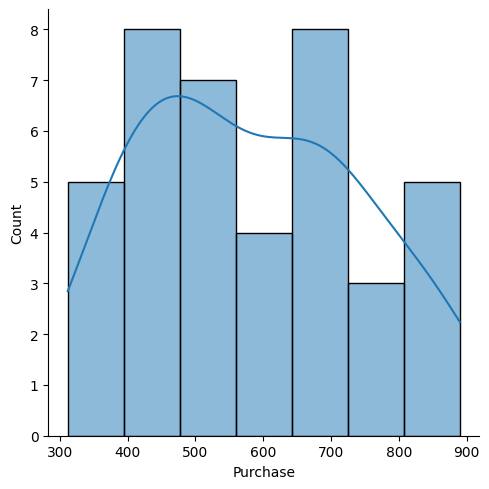

In [53]:
create_displot(df_test, "Purchase")

c:\Users\TOSHIBA\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


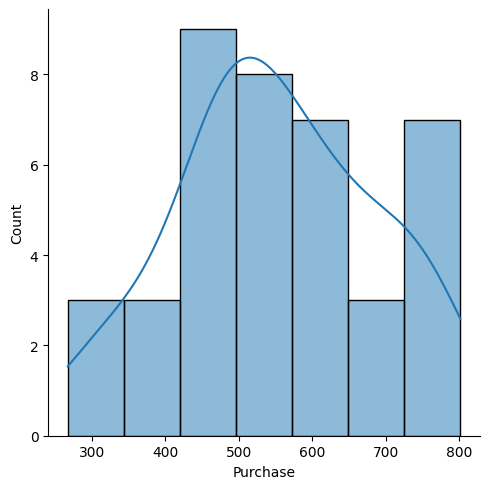

In [54]:
create_displot(df_control, "Purchase")

In [35]:
# Varyans Homojenliği

# H0 : Varyanslar homojendir.
# H1 : Varyanslar homojen değildir.

test_stat, pvalue = levene(df.loc[df["group"] == "test", "Purchase"],\
                           df.loc[df["group"] == "control", "Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

if pvalue < 0.05:
    print("H0 reddedilir, varyanslar homojen değildir")
else: 
    print("H0 reddedilemez, varyanslar homojendir")

Test Stat = 2.6393, p-value = 0.1083
H0 reddedilemez, varyanslar homojendir


Normallik ve varyans homojenliği varsayımları sağlandığından parametrik bir test kullanmalıyız.(t-testi)

In [36]:
# Adım 3 : Hipotezi uygula

# HO : M1 = M2 
# H1 : M1 ! = M2 

test_stat, pvalue = ttest_ind(df.loc[df["group"] == "test", "Purchase"],\
                           df.loc[df["group"] == "control", "Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


Test Stat = 0.9416, p-value = 0.3493


In [39]:
# Adım 4 : p değerini yorumla

if pvalue < 0.05:
    print("H0 reddedilir, kontrol grubu ve test grubu satın alma değerleri arasında istatistiksel olarak fark vardır")
else: 
    print("H0 reddedilemez, kontrol grubu ve test grubu satın alma değerleri arasında istatistiksel olarak bir fark yoktur")

H0 reddedilemez, kontrol grubu ve test grubu satın alma değerleri arasında istatistiksel olarak bir fark yoktur


Yapılan A/B Test analizi sonucu "averagebidding" ve "maximumbidding" teklif verme türleri arasındaki ortalama satın alma miktarı arasında anlamlı bir fark yoktur. 